<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2022/blob/main/Seminars/lab_04_ROCAUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confusion matrix


     sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
 
     where the normalize parameter takes the values {'true', 'pred', 'all'} - normalization, respectively, by rows (True classes), by columns (Predicted classes) or normalization by the total number of objects in the sample.
     The default value is normalize=None (each cell of the matrix will contain the number of  objects)
     
#### For a simple visualization of confusion matrix, we use the class:

    sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, *, display_labels=None)

In [ ]:

from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)
X.shape

#### Fit model

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                    random_state=0)
clf = LogisticRegression(multi_class='ovr',max_iter=10)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10, multi_class='ovr')

Display the confusion matrix on the training sample with the number of samples in each group

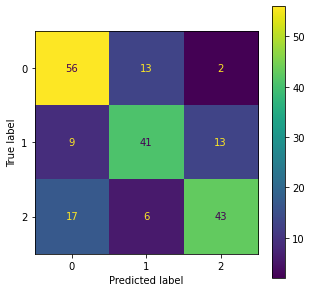

In [49]:
from pylab import rcParams
rcParams['figure.figsize'] = 5,5

predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

#### Display the confusion matrix on the test sample with the share of samples in each group

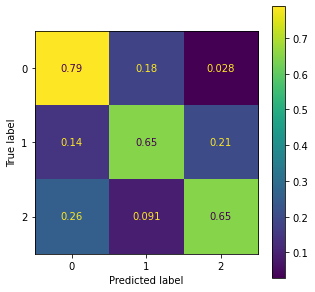

In [50]:


predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

# Quality metrics for 2-class tasks

#### Let's take a 2-class task with customers' churn from a telecom operator.

It is important for us to train the model to predict class '1' (customer churn) well in order to efficiently allocate marketing resources to customers with a high probability of churn. At the same time, there are 6 times fewer observations of class 1 in the sample than of class 0. And, using the dummy model, we will immediately get a good accuracy.

But among all the customers we want to  predict those with a large expected LTV(life-time value).

Then we need:
1. fit a regression model that predicts LTV
2. fit a classification model that predict probability of churn very well
3. treat LTV * probability(churn) as expected loss for each customer
4. select customers with greater loss for marketing company or bonus scheme

But how to detect which models are good at probability prediction?

In [51]:
!wget -N https://raw.githubusercontent.com/yandexdataschool/MLatImperial2022/main/Data/telecom_churn2.csv

--2022-01-28 12:54:36--  https://raw.githubusercontent.com/yandexdataschool/MLatImperial2022/main/Data/telecom_churn2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283308 (277K) [text/plain]
Saving to: ‘telecom_churn2.csv’

telecom_churn2.csv  100%[===================>] 276.67K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2022-01-28 12:54:36 (18.4 MB/s) - ‘telecom_churn2.csv’ saved [283308/283308]



In [52]:
# telecom company data preparation
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
random_state=0
df = pd.read_csv('telecom_churn2.csv')
d = {'Yes' : 1, 'No' : 0}
df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')
df=df.drop('State',axis=1)

y=df['Churn']
X=df.drop('Churn',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,     random_state=0)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)
X_train.head()
                                                    
numeric_features = numeric_data.columns
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")     


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore",sparse=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
X_train_transformed=column_transformer.fit_transform(X_train)
X_test_transformed=column_transformer.fit_transform(X_test)

#### Fit logistic regression model:

In [53]:
from sklearn.linear_model import LogisticRegressionCV

model=LogisticRegressionCV(penalty='l2',Cs=[0.0001,0.001,0.01,0.1,1,10,100],cv=5,
                                       random_state=0)
model.fit(X_train_transformed,y_train)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], cv=5,
                     random_state=0)

#### Calculate accuracy_score:

In [54]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_transformed)
print(accuracy_score(y_test,y_pred))

0.8680659670164917


#### Assuming by the accuracy_score, the resulting model seems to be pretty good

#### Make the confusion matrix:

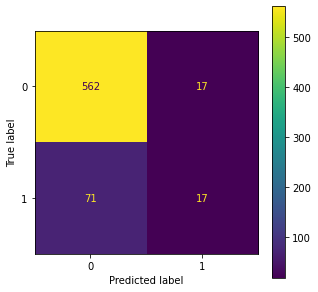

In [55]:

cm = confusion_matrix(y_test, y_pred,labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

#### From the confusion matrix, we can see that the classes are highly imbalanced. Even though the accuracy_score is not bad, only a minority of the objects in class '1' are predicted correctly.

It is much more useful to focus on metrics:

1) precision (precision)
2) completeness (recall)
3) F-measures
4) weighted F-measure

<center>
<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3292712%2F4fc7e8af4d3ecfd15c73f72fba82d027%2FconfusionMatrxiUpdated.jpg?generation=1574221845511874&alt=media" width=70%/>
</center>


To calculate these metrics, we will use the classes:

- sklearn.metrics.precision_score(y_true, y_pred,...)
- sklearn.metrics.recall_score(y_true, y_pred,...)
- sklearn.metrics.f1_score(y_true, y_pred,...)
- sklearn.metrics.fbeta_score(y_true, y_pred, *, beta,...)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width=35%/>





The **precision** is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is intuitively the ability of the classifier to find all the positive samples.

The **F1** score can be interpreted as a weighted average of the precision and recall


In [56]:
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score, fbeta_score
def print_metrics(y_test, y_pred):
    print(f'precision_score={precision_score(y_test, y_pred):.3f}')
    print(f'recall_score={recall_score(y_test, y_pred):.3f}')
    print(f'f1_score={f1_score(y_test, y_pred):.3f}')
    print(f'f_score (beta=2)={fbeta_score(y_test, y_pred, beta=2):.3f}')
    print(f'f_score (beta=4)={fbeta_score(y_test, y_pred, beta=4):.3f}')
    
print_metrics(y_test, y_pred)


precision_score=0.500
recall_score=0.193
f1_score=0.279
f_score (beta=2)=0.220
f_score (beta=4)=0.200


## ROC curve

To get ROC curve we will change the decision rule according to which we assign an object to a positive class. More precisely, we will adjust $\alpha$, where

$$\hat y(x) = sign(\beta^T x - \alpha)$$
$$TPR = TPR(\alpha)$$
$$FPR = FPR(\alpha)$$
The area under the curve is calculated by the formula:
$$AUC = \int_{-\infty}^{\infty} {TPR} \,d{FPR}$$


<img src="https://editor.analyticsvidhya.com/uploads/23302main-qimg-7fc9e8601c15e33945720800aa237a7f.png" width=60%/>


### Plotting of ROC curve

        sklearn.metrics.plot_roc_curve(estimator, X, y, *,...)

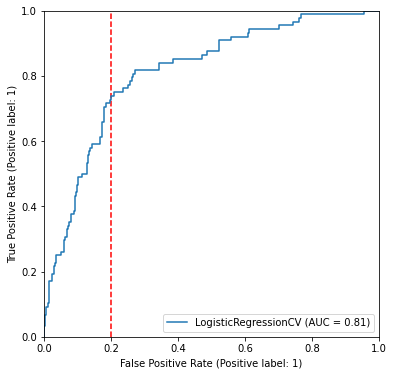

In [57]:
from sklearn.metrics import plot_roc_curve

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot( 1, 1, 1 )
plt.plot([0.2, 0.2], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plot_roc_curve(model,X_test_transformed,y_test,ax=ax);


http://arogozhnikov.github.io/RocCurve.html

http://arogozhnikov.github.io/2015/10/05/roc-curve.html



### Let's compare ROC curves of different models


Accuracy baseline

In [58]:

1-y.mean()

0.8550855085508551

<Figure size 720x720 with 0 Axes>

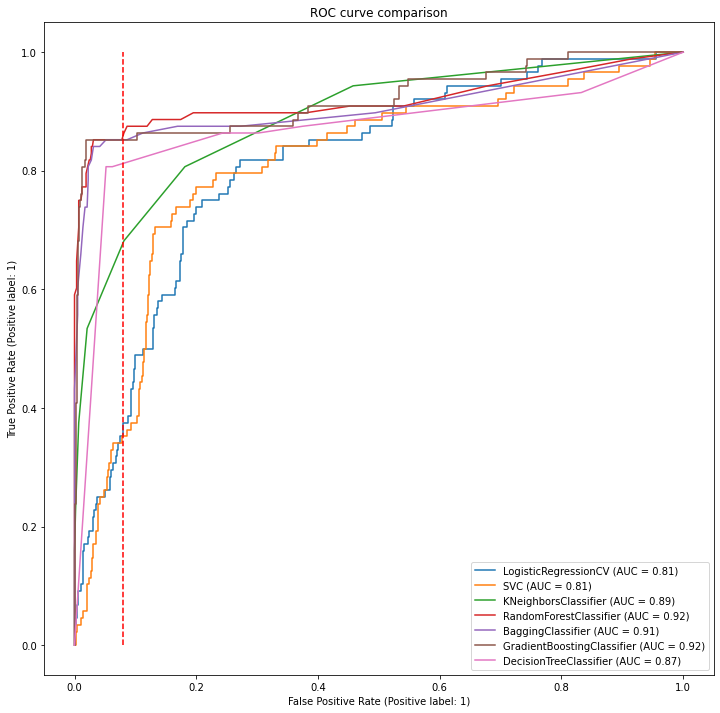

In [60]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
#fit models
rcParams['figure.figsize'] = 12,12
base_model=DecisionTreeClassifier()
svc = SVC(kernel='rbf',gamma=1,probability=True)
svc.fit(X_train_transformed, y_train)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_transformed, y_train)
tree=DecisionTreeClassifier(max_depth=10)
tree.fit(X_train_transformed,y_train)
logreg=LogisticRegressionCV(penalty='l2',Cs=[0.0001,0.001,0.01,0.1,1,10,100],cv=5,
                                       random_state=0)
logreg.fit(X_train_transformed, y_train)
forest = RandomForestClassifier(n_estimators=89,max_samples=0.8,random_state=0)
forest.fit(X_train_transformed, y_train)
bagging = BaggingClassifier(base_estimator=base_model,max_samples=0.9,max_features=1.0,
                        n_estimators=21, random_state=0)
bagging.fit(X_train_transformed, y_train)
boost = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1,
    max_depth=5, random_state=0)
boost.fit(X_train_transformed, y_train)


#plot roc curves
plt.figure(figsize=(10,10))
log_disp = plot_roc_curve(logreg, X_test_transformed, y_test)
svc_disp = plot_roc_curve(svc, X_test_transformed, y_test, ax=log_disp.ax_)
knn_disp = plot_roc_curve(knn, X_test_transformed, y_test, ax=log_disp.ax_)
forest_disp = plot_roc_curve(forest, X_test_transformed, y_test, ax=log_disp.ax_)
bagging_disp = plot_roc_curve(bagging, X_test_transformed, y_test, ax=log_disp.ax_)
boosting_disp = plot_roc_curve(boost, X_test_transformed, y_test, ax=log_disp.ax_)
tree_disp = plot_roc_curve(tree, X_test_transformed, y_test, ax=log_disp.ax_)
plt.plot([0.08, 0.08], [0, 1],'r--')
plt.title(("ROC curve comparison"))

plt.show()


http://arogozhnikov.github.io/RocCurve.html

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Let's imaging that for each correct guess about new object you are paid. But the cost for correctly guessing signal and background are different.

To maximize the income, the threshold for decision rule should correspond to point at ROC curve, where loss is minumum

One of such examples is email spam filtering: cost for incorrect classification of good letter is times higher than cost for making wrong prediction for spam letter.



#### TP-TN distribution graphs

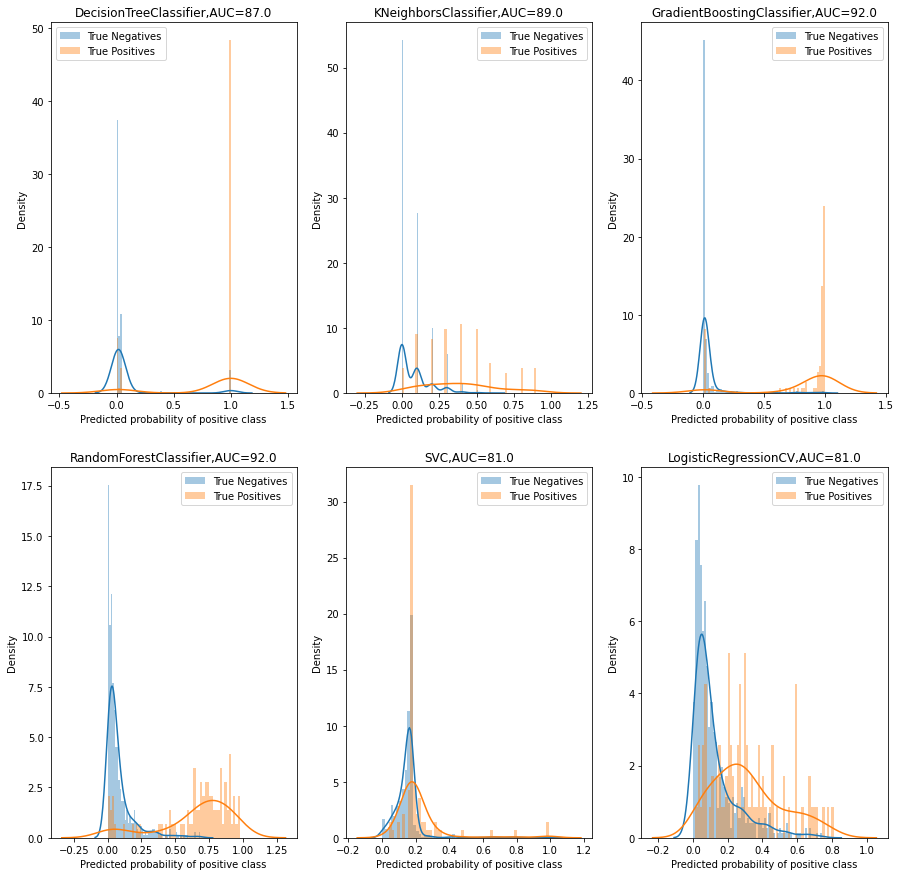

In [62]:
import warnings
warnings.simplefilter("ignore")
clfs = [tree,knn,boost,forest,svc,logreg]
from sklearn.metrics import roc_auc_score
rcParams['figure.figsize'] = 15,15


for i, clf in enumerate(clfs):
    plt.subplot(2, 3,  i+1)    
    probabilities=clf.predict_proba(X_test_transformed)[:, 1]
    y_test_prob=np.concatenate((probabilities[:,np.newaxis],y_test[:,None]),axis=1)
    tp=y_test_prob[y_test_prob[:,1]>0]
    tn=y_test_prob[y_test_prob[:,1]<1]

    sns.distplot(tn[:,0],bins=60,hist=True,kde=True,label="True Negatives")
    sns.distplot(tp[:,0],bins=60,hist=True,kde=True,label="True Positives")


    y_pred=clf.predict_proba(X_test_transformed)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred)*100
    plt.title(f"{clf.__class__.__name__},AUC={str(roc_auc.round(0))}", fontsize=12)
    
    plt.xlabel("Predicted probability of positive class")
    plt.legend()
  


###  AUC ROC:
        
        sklearn.metrics.roc_auc_score(y_true, y_score, *, ...)

In [63]:
from sklearn.metrics import roc_auc_score
y_pred=logreg.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc.round(4))

0.5


###  brier score 
MSE of probabilities vs targers

In [64]:
from sklearn.metrics import brier_score_loss
for clf in [logreg,knn,bagging,forest] :
    y_prob=clf.predict_proba(X_test)
    brier = brier_score_loss(y_test, y_prob[:,1])
    print(type(clf).__name__,':',brier.round(3))


LogisticRegressionCV : 0.868
KNeighborsClassifier : 0.278
BaggingClassifier : 0.545
RandomForestClassifier : 0.445


In [65]:
#<YOUR TURN>
#fit any model on this data using GridSearchCV with scoring='recall'
#is there any difference in best_params_ comaring to using default scoring method?

## Bonus part: model's calibration.

Reliability diagramms are used to assess how well the model is calibrated.

Reliability is a measure about the alignment of the model confidence and the model real performance. A reliable model is able to reflect its real performance through the confidence that it has over the samples. So we can direct evaluate the usability of the model through the evaluation of the confidence that it has during inference. This gives us a very descent and efficient method for such evaluation.

Reliability diagram

Before we go into quantify the measure, first we need to construct a reliability diagram. To construct it, we will do the followings:
split the confidence space into several bins with constant separation.
run the model on the test data and allocate them with respect to the confidence of them.
compute the expectation accuracy of each bins and plot them as accuracy vs confidence.

The diagonal indicates a perfect reliability. The dotted horizontal line is the no resolution line, indicating the mean probability in the bin. 

<img src=https://miro.medium.com/max/700/1*ia-FW6n6SsSCeCJib0POfA.png width="70%" />


If the blue bar is higher than the pink one, the model is said to be under-confident (**under-confident**), if it is lower, it is said to be over-confident or “over-confident” (**over-confident**).




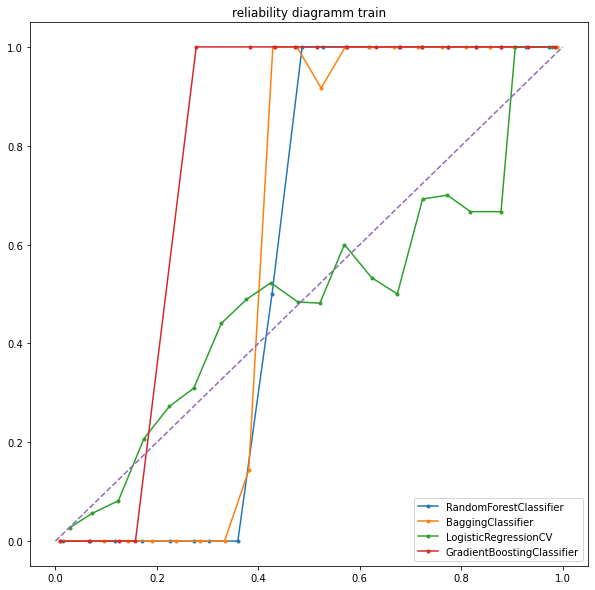

In [70]:
from sklearn.calibration import calibration_curve
rcParams['figure.figsize'] = 10,10
# predict probabilities
for clf in [forest,bagging,logreg,boost]:
    probs = clf.predict_proba(X_train_transformed)[:,1]
    # reliability diagram
    fop, mpv = calibration_curve(y_train, probs, n_bins=20)

    # plot model reliability
    plt.plot(mpv, fop, marker='.',label=type(clf).__name__)
    plt.title("reliability diagramm train")
    plt.legend()
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

class sklearn.calibration.CalibratedClassifierCV(base_estimator=None, *, method='sigmoid', cv=None, n_jobs=None, ensemble=True)
- method{‘sigmoid’, ‘isotonic’}, default=’sigmoid’
- cvint, cross-validation generator, iterable or “prefit”

Random forest calibration

In [71]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_forest = CalibratedClassifierCV(base_estimator=forest,method='isotonic', cv='prefit')
calibrated_forest.fit(X_train_transformed,y_train)
calibrated_tree = CalibratedClassifierCV(base_estimator=tree,method='isotonic', cv='prefit')
calibrated_tree.fit(X_train_transformed,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=10),
                       cv='prefit', method='isotonic')

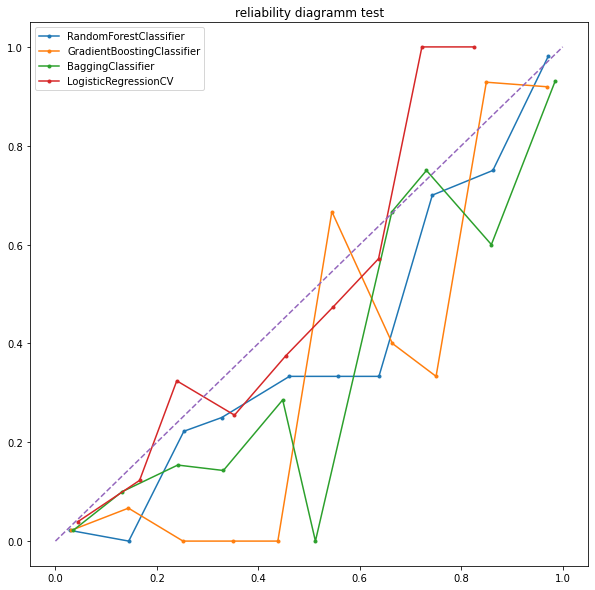

In [73]:
for clf in [forest,boost,bagging,logreg]:
    calibrated_model = CalibratedClassifierCV(base_estimator=clf,method='isotonic',cv=3)
    calibrated_model.fit(X_train_transformed,y_train)
    probs = calibrated_model.predict_proba(X_test_transformed)[:,1]
    
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10)
    # plot perfectly calibrated

    # plot model reliability
    plt.plot(mpv, fop, marker='.',label=type(clf).__name__)
    plt.legend()
plt.title("reliability diagramm test")
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')    
plt.show()

#### Often we need model with good calibrability (ability to be calibrated well) and appropiate ROC AUC. (or we can choose the best model among models with the same ROC AUC by calibarability on a certain interval  of probabilities. For example if we won't   take into account customers with probability<0.7)

See also: Kolmogorov-Smirnov distance

### Bonus part 2: Multiclass classification

<center>
<img src="https://drek4537l1klr.cloudfront.net/rhys/v-3/Figures/CH06_FIG_8_MLR.png" width=50%/>
</center>

### One versus all:

<img src="https://paros-hotels.biz/images/machine/Difference-between-classification-and-clustering-in-data-mining-closed-5.png" width=50%/>

#### One vs all

One-vs-rest (OvR for short, also referred to as One-vs-All or OvA) is a heuristic method for using binary classification algorithms for multi-class classification.

It involves splitting the multi-class dataset into multiple binary classification problems. A binary classifier is then trained on each binary classification problem and predictions are made using the model that is the most confident.

Some classifier has parametr *multi_class*. For instance, for Logistic Regression we have:

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

model = LogisticRegression(multi_class='ovr')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


In [ ]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
y_pred.shape, y_proba.shape

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Another approach is to use implemented in sklearn OneVsRestClassifier:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

model = LogisticRegression()

ovr = OneVsRestClassifier(model)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)
y_proba = ovr.predict_proba(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Look at metrics, they are exactly the same as in previous case.

**One vs one**

One-Vs-One for Multi-Class Classification
One-vs-One (OvO for short) is another heuristic method for using binary classification algorithms for multi-class classification.

Like one-vs-rest, one-vs-one splits a multi-class classification dataset into binary classification problems. Unlike one-vs-rest that splits it into one binary dataset for each class, the one-vs-one approach splits the dataset into one dataset for each class versus every other class.

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

model = LogisticRegression()
ovo = OneVsOneClassifier(model)
ovo.fit(X_train, y_train)
y_pred = ovo.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))